# A Thorough Introduction to YOLO: You Only Look Once

In this Jupyter notebook, we will explore **YOLO** (short for "You Only Look Once"), one of the most popular and influential methods for real-time object detection.

We will cover:
- High-level motivation and applications
- Comparison with earlier methods such as DPM and R-CNN
- The YOLO architecture details
- The training process, including how the bounding boxes and class probabilities are learned
- The loss function
- Limitations of the original YOLO (YOLOv1)
- References and further resources

> **Note**: This notebook is based on knowledge from the video [*How YOLO Object Detection Works*](https://www.youtube.com/watch?v=svn9-xV7wjk) and additional insights from the original YOLO research paper and subsequent works. We include math notations using the syntax required: inline math with $...$ and display math with $$...$$.

Let's begin!

## 1. Introduction

Object detection is the task of not only recognizing which objects are present in an image but also drawing bounding boxes around them (and sometimes assigning confidence scores). Being able to do this in real-time is crucial for many applications, such as:

- **Video Surveillance**: Monitoring crowds, detecting intrusions, tracking suspicious activities.
- **Autonomous Vehicles**: Recognizing pedestrians, cars, and traffic signs.
- **Medical Imaging**: Locating and identifying certain anatomical structures or abnormalities.
- **Robotics**: Allowing robots to perceive and navigate the environment safely.

YOLO is famous for its ability to perform detection **very quickly** (in real-time on many modern GPUs) while maintaining competitive accuracy. This speed-accuracy trade-off makes YOLO extremely popular and influential in both academic research and industrial applications.


## 2. Predecessors to YOLO

### Deformable Parts Model (DPM)

The **Deformable Parts Model (DPM)** was an early approach to object detection. It uses a sliding-window technique, where:
- Filters represent whole objects and parts of objects.
- If a sufficiently strong correlation of parts is detected in a given window, the algorithm produces a high detection score.

A limitation of this approach is that it processes the image many times (in different sliding windows), which can be slow.

### Region-Based CNN (R-CNN)

The **R-CNN** approach (and subsequent Fast R-CNN, Faster R-CNN, etc.) uses a two-stage pipeline:
1. **Region Proposal**: Propose candidate regions (bounded boxes) in an image where objects may be.
2. **CNN-based Classification**: Extract a feature vector for each region via a CNN, then classify it using an SVM or fully connected layers.

While more accurate than earlier methods, these R-CNN variants still require multiple passes over proposed regions, which often slows down inference. YOLO, on the other hand, solves detection in a single forward pass of a network, leading to much faster detection speeds.


## 3. YOLO: The Key Idea

The acronym **YOLO** stands for **You Only Look Once**. Unlike previous object detection frameworks that examine an image multiple times (e.g., through sliding windows or region proposals), YOLO essentially "looks" at the image **exactly once** to predict bounding boxes and class probabilities.

To achieve this, YOLO re-frames object detection as a **single regression problem**:

1. **Split** the image into an $S \times S$ grid.
2. **Predict** bounding boxes and class probabilities **for each grid cell**.
3. **Combine** these predictions to get final detections via non-max suppression.

In the original YOLO paper (often called YOLOv1), $S=7$ and each grid cell predicts $B=2$ bounding boxes. The model was trained on the Pascal VOC dataset, which contained $C=20$ object classes.


## 4. The YOLO Architecture

### 4.1 Overview

A high-level YOLO pipeline for an input image might look like this:

1. **Input**: An image of size, for example, $448\times448$ pixels (plus 3 color channels).
2. **Convolutional Layers**: A series of convolutional and pooling layers distill the image into a more compact feature representation.
3. **Fully Connected Layers**: Two fully connected layers that produce the final $(S \times S)$ predictions, each containing $B \times 5 + C$ numbers.

In YOLOv1:
- $S = 7$ (so we get $7\times7 = 49$ grid cells).
- $B = 2$ bounding boxes per cell.
- $C = 20$ classes (for the Pascal VOC dataset).

### 4.2 Output Encoding

For **each grid cell**, YOLO outputs a vector of length $B\times 5 + C$, which includes:

1. **Bounding box coordinates**: $x, y, w, h$ for each of the $B$ boxes.
2. **Confidence**: $\text{confidence}$ for each box. This confidence is meant to represent how certain the model is that an object is present in that box.
3. **Class probabilities**: $P(\text{class}_1), \dots, P(\text{class}_C)$.

Thus, for $B=2$ and $C=20$, that is $2\times5 + 20 = 30$ numbers per grid cell.

#### Why Square Roots for $w$ and $h$?

In YOLOv1, instead of directly predicting $w$ and $h$, the **square roots** of $w$ and $h$ are predicted. This helps the model handle the fact that an absolute error of 0.1 in width is more significant for smaller objects than for larger ones. Taking the square root effectively reduces the penalty for large bounding boxes.


## 5. Training YOLO

### 5.1 Assigning Each Object to a Grid Cell

During training, each ground truth bounding box has a center $(x_{\text{center}}, y_{\text{center}})$, which lies within exactly **one** of the $S\times S$ grid cells. That cell is then responsible for predicting that object.

### 5.2 Ground Truth Format

For each ground truth bounding box, we have:
- $x, y$: center coordinates of the object **relative** to the top-left corner of the responsible grid cell, each in $[0,1]$.
- $w, h$: width and height of the bounding box, **relative** to the entire image, also each in $[0,1]$.
- One-hot label for the $C$ classes: $[1, 0, ..., 0]$ if it's, for example, a person, etc.

### 5.3 Confidence Score

The **confidence** for a predicted bounding box is computed as:

$$\text{confidence} = P(\text{object exists in the box})\times \text{IOU}(\text{pred},\text{truth})$$

However, for simplicity, YOLOv1's final training objective sets the ground truth confidence to be the **Intersection over Union (IOU)** of the predicted box with the ground truth box if that cell is responsible for an object, or $0$ if the cell does not contain an object.

### 5.4 Multiple Bounding Boxes per Cell

Each grid cell predicts $B$ bounding boxes. During training, we **only assign exactly one** of those $B$ predictions to the ground truth box—the one with the highest IOU. The other bounding boxes in that cell are treated as having no object (unless there are multiple ground truth objects whose centers fall into the same cell, which is relatively rare in YOLOv1). This encourages each predicted bounding box to "specialize" in different shapes or classes of objects.


## 6. YOLO Loss Function

A key characteristic of YOLO (v1) is that it uses a simple **sum of squared errors** across all the outputs (box coordinates, confidence, and class probabilities). The total loss, $\mathcal{L}$, can be broken into **three** components:

1. **Coordinate (Localization) Loss**
2. **Confidence Loss**
3. **Class Probability Loss**

We will denote:
- $\lambda_{coord}$ as a scaling factor (often set to 5) that up-weights coordinate error.
- $\lambda_{noobj}$ as a scaling factor (often set to 0.5) that down-weights the confidence error for grid cells that do **not** contain any object.

### 6.1 Coordinate Loss

For each grid cell $i$ and bounding box $j$, we only compute the coordinate error if that bounding box is "responsible" for an object. We sum over the squared differences of the predicted $(x, y)$ from the ground truth and the squared differences of $(\sqrt{w}, \sqrt{h})$ from the ground truth values:

$$
\lambda_{coord}\sum_{i=1}^{S^2} \sum_{j=1}^B \mathbf{1}_{ij}^{obj} \big[ (x_i - \hat{x}_i)^2 + (y_i - \hat{y}_i)^2 + (\sqrt{w_i} - \sqrt{\hat{w}_i})^2 + (\sqrt{h_i} - \sqrt{\hat{h}_i})^2 \big].
$$

Here, $\mathbf{1}_{ij}^{obj}$ is an indicator that equals 1 if the $j$th bounding box in cell $i$ is responsible for an object, and 0 otherwise.

### 6.2 Confidence Loss

Two situations:

1. **Cell does contain an object** ($\mathbf{1}_{ij}^{obj} = 1$): The confidence should reflect the IOU between the predicted box and the ground truth.
2. **Cell does not contain an object** ($\mathbf{1}_{ij}^{obj} = 0$): The confidence should be zero.

The loss term is:

$$
\sum_{i=1}^{S^2} \sum_{j=1}^B \mathbf{1}_{ij}^{obj}(C_i - \hat{C}_i)^2 + \lambda_{noobj}\sum_{i=1}^{S^2} \sum_{j=1}^B \mathbf{1}_{ij}^{noobj} (C_i - \hat{C}_i)^2,
$$

where $C_i$ is the predicted confidence and $\hat{C}_i$ is the ground truth confidence (the IOU if cell $i$ has an object, or 0 otherwise). And $\mathbf{1}_{ij}^{noobj} = 1 - \mathbf{1}_{ij}^{obj}$.

### 6.3 Class Probability Loss

Finally, for the **class probabilities**, we only sum the squared error in cells that actually contain an object:

$$
\sum_{i=1}^{S^2} \mathbf{1}_i^{obj} \sum_{c=1}^{C} (p_i(c) - \hat{p}_i(c))^2.
$$

Here, $p_i(c)$ is the predicted probability of class $c$ in cell $i$, and $\hat{p}_i(c)$ is the ground truth label (1 for the true class, 0 for the others if we assume a single class per object in YOLOv1).

### 6.4 Overall Loss

Putting it all together:

$$
\mathcal{L} = \underbrace{\lambda_{coord}\sum_{i=1}^{S^2}\sum_{j=1}^B\mathbf{1}_{ij}^{obj}\big[(x_i - \hat{x}_i)^2 + (y_i - \hat{y}_i)^2 + (\sqrt{w_i} - \sqrt{\hat{w}_i})^2 + (\sqrt{h_i} - \sqrt{\hat{h}_i})^2\big]}_{\text{Coordinates}} 
+ \underbrace{\sum_{i=1}^{S^2}\sum_{j=1}^B\mathbf{1}_{ij}^{obj}(C_i - \hat{C}_i)^2}_{\text{Confidence (obj)}} 
+ \underbrace{\lambda_{noobj}\sum_{i=1}^{S^2}\sum_{j=1}^B\mathbf{1}_{ij}^{noobj}(C_i - \hat{C}_i)^2}_{\text{Confidence (noobj)}} 
+ \underbrace{\sum_{i=1}^{S^2}\mathbf{1}_i^{obj}\sum_{c=1}^{C} (p_i(c) - \hat{p}_i(c))^2}_{\text{Class probs}}.
$$

In practice, typical hyperparameters are $\lambda_{coord} = 5$ and $\lambda_{noobj} = 0.5$ (from the original YOLO paper [1]).


## 7. Non-Max Suppression

After the model outputs the bounding boxes and confidences, we usually apply **Non-Max Suppression** (NMS) to remove overlapping detections. The idea:

1. Sort predictions by confidence.
2. For the top confidence bounding box, remove any other boxes that have high IOU (e.g. IOU $> 0.5$) with it.
3. Repeat until no boxes remain or a maximum number of boxes is reached.

This step helps remove duplicate detections of the same object.


## 8. Limitations of YOLOv1

While YOLOv1 was a breakthrough in real-time detection, it has a few known limitations:

1. **Each grid cell can only predict one class**. If two objects of different classes fall into the same grid cell, YOLO may only predict one of them.
2. **Fixed number of bounding boxes per cell**. If more than $B$ objects appear in the same cell, YOLOv1 cannot properly model them.
3. **Challenges with small objects**: If a small object is entirely within one cell's boundary, the coordinate predictions can be tricky. Also, if that small object spans multiple cells, there's confusion about which cell truly "owns" it.
4. **Loss function weighting**: The same absolute error in coordinates is more severe for small objects, and YOLO only partially addresses this by predicting $\sqrt{w}$ and $\sqrt{h}$.

Subsequent YOLO releases (YOLOv2, YOLOv3, YOLOv4, YOLOv5, YOLOv8, etc.) introduced improvements to address some of these drawbacks, such as using **anchor boxes** instead of direct bounding box predictions, better backbone architectures, and multi-scale training.


## 9. Example Usage in Code

Below is a **very** simplified example (using PyTorch) of how one might:
1. Load a pre-trained YOLO model (e.g., from a modern library like `ultralytics` or `torchvision`).
2. Run inference on an image.
3. Visualize detections.

```python
import torch
from PIL import Image
import matplotlib.pyplot as plt

# Suppose we have the ultralytics YOLO library installed
# pip install ultralytics
from ultralytics import YOLO

# 1. Load a pretrained YOLO model
model = YOLO('yolov8n.pt')  # YOLOv8 nano model for example

# 2. Load an image
img_path = 'example.jpg'
image = Image.open(img_path)

# 3. Run inference
results = model.predict(source=img_path)

# 4. Visualize results
# The 'results' object can be plotted directly
results[0].plot()
plt.show()
```

> **Note**: This is a modern YOLO variant (YOLOv8), which has many enhancements over YOLOv1. The fundamental idea of seeing the image **once** still remains.


## 10. Conclusions

- **YOLOv1** revolutionized object detection by showing that it could be reframed as a single pass, end-to-end regression problem.
- It significantly speeds up detection and achieves a balance of accuracy and speed that many applications desire.
- **Later YOLO versions** improved upon YOLOv1's shortcomings, adding anchor boxes, better backbones, and multi-label classification capabilities.

Ultimately, the YOLO family remains one of the **go-to** methods for real-time object detection in both research and industry.


## 11. References

1. **YOLOv1**: Redmon, J., Divvala, S., Girshick, R., & Farhadi, A. (2016). [*You Only Look Once: Unified, Real-Time Object Detection*](https://arxiv.org/abs/1506.02640). *CVPR 2016*.
2. **YOLOv2**: Redmon, J., & Farhadi, A. (2017). [*YOLO9000: Better, Faster, Stronger*](https://arxiv.org/abs/1612.08242). *CVPR 2017*.
3. **YOLOv3**: Redmon, J., & Farhadi, A. (2018). [*YOLOv3: An Incremental Improvement*](https://arxiv.org/abs/1804.02767).
4. **Deformable Parts Model**: Felzenszwalb, P. F., Girshick, R. B., McAllester, D., & Ramanan, D. (2008). [*Object Detection with Discriminatively Trained Part-Based Models*](https://ieeexplore.ieee.org/document/5206594). *IEEE Transactions on Pattern Analysis and Machine Intelligence*.
5. **R-CNN**: Girshick, R., Donahue, J., Darrell, T., & Malik, J. (2014). [*Rich feature hierarchies for accurate object detection and semantic segmentation*](https://arxiv.org/abs/1311.2524). *CVPR 2014*.

Additional YOLO variants (YOLOv4, YOLOv5, YOLOv7, YOLOv8, etc.) also exist and incorporate many further improvements, making them more accurate, faster, or both.

---

Thank you for reading this notebook!

# Running YOLOv8 for Object Detection

This notebook shows how to:
1. Install the [Ultralytics YOLO](https://github.com/ultralytics/ultralytics) library.
2. Download an example image from the web.
3. Load a pre-trained YOLO model.
4. Run inference (object detection) on the downloaded image.
5. Visualize and interpret the results.

We will use the YOLOv8 model from Ultralytics, which is a popular and actively maintained version of YOLO.

## 1. Install and Import Dependencies

We will first ensure that the **ultralytics** package is installed. Then we will import the necessary modules.

In [4]:
!pip install -q ultralytics

In [2]:
!pip install opencv-python

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.8/54.8 MB 35.1 MB/s eta 0:00:0000:0100:01


In [5]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import cv2
from PIL import Image
from ultralytics import YOLO


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/Users/amirhosseindaraie/Library/Application Support/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


## 2. Download an Example Image

We will download an image from the web using `wget` or any similar tool. For demonstration, let's pick a sample image that has multiple objects (e.g., a street scene or a busy market) so we can see YOLO detect many things.

> **Note**: If you are running this locally on Windows, you might need to install `wget` or use alternative methods to download.


Let's quickly confirm the image is saved and display its thumbnail (if you're in a notebook environment).

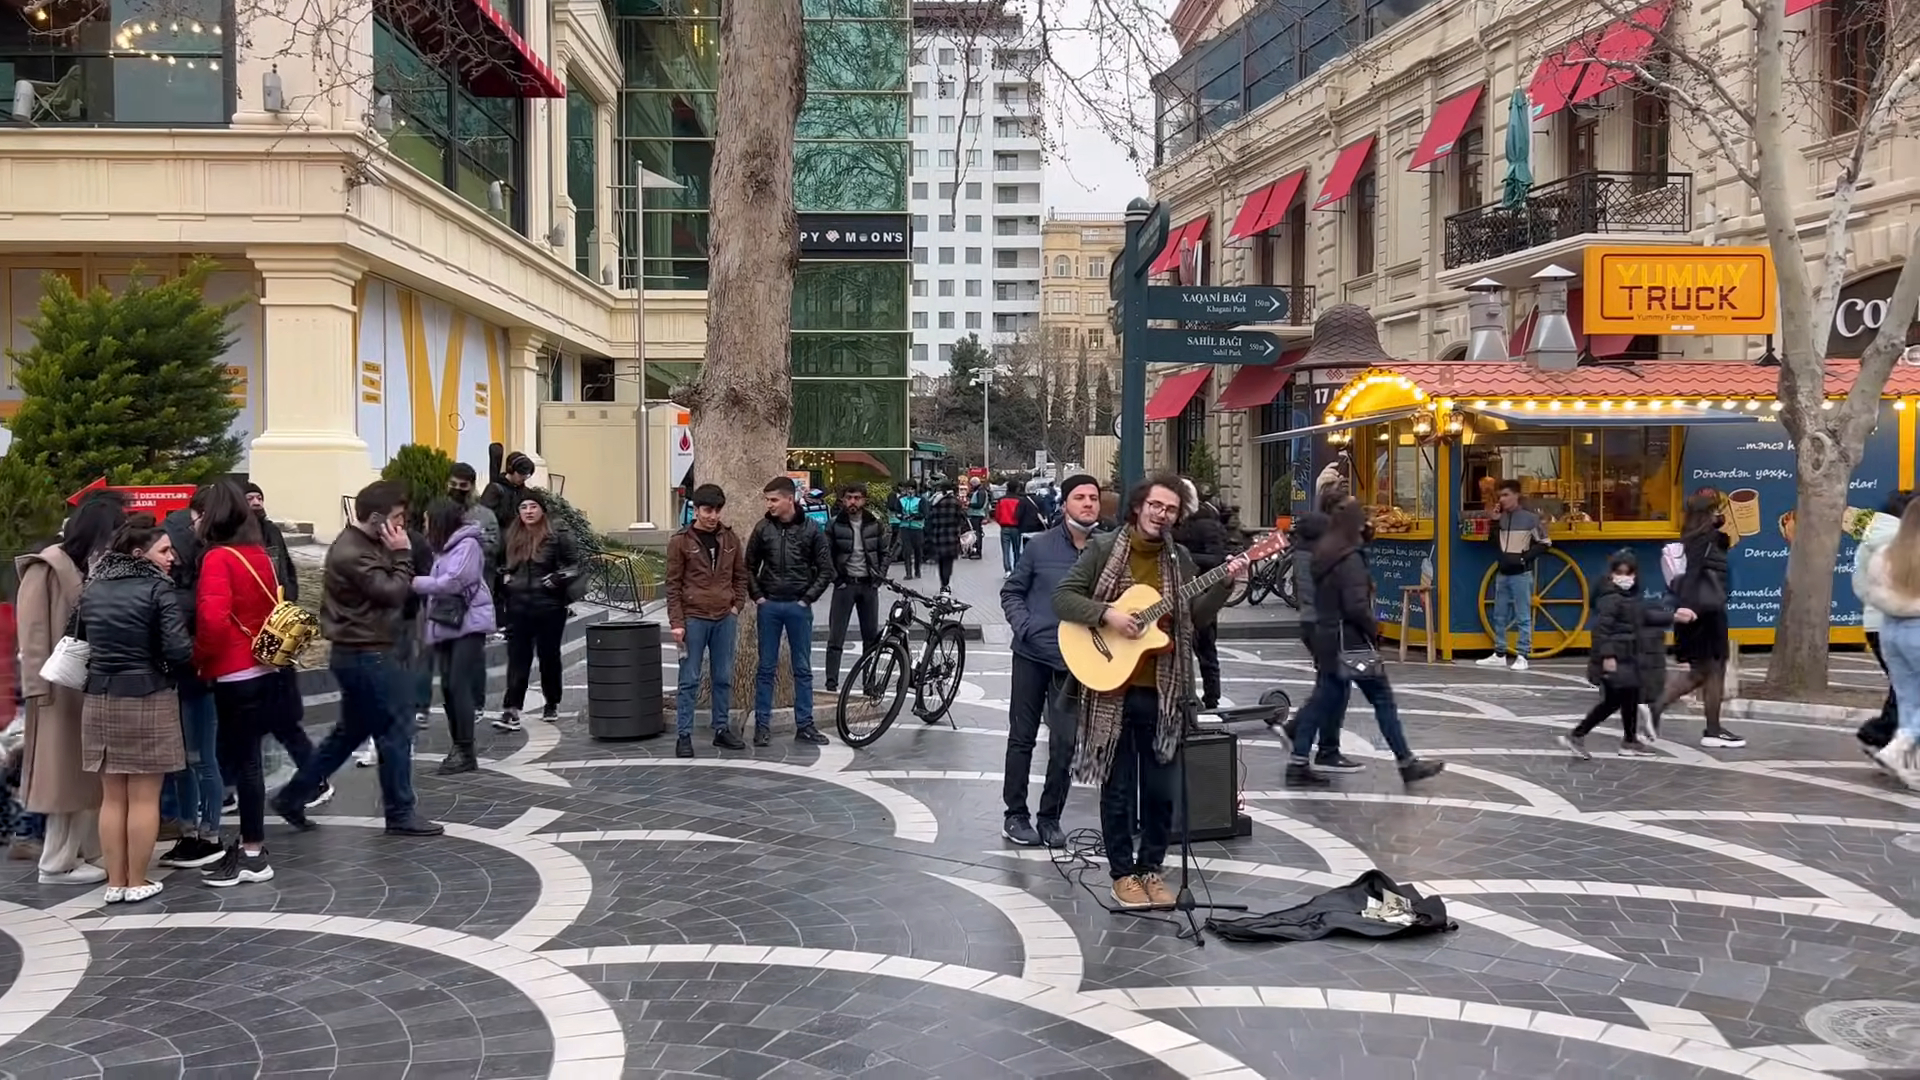

In [ ]:
from IPython.display import Image as IPythonImage
IPythonImage(filename='street.jpg', width=400)

## 3. Load a Pre-trained YOLO Model

Ultralytics provides several YOLOv8 variants (nano, small, medium, large, x-large). We'll use **YOLOv8n** ("nano" model), which is smaller and faster. You can easily switch to `yolov8s.pt`, `yolov8m.pt`, etc., for larger models.


In [17]:
# Load the YOLOv8 nano model from ultralytics
model = YOLO('yolov8n.pt')  # or 'yolov8s.pt', 'yolov8m.pt', etc.

## 4. Run Inference

We call the model's `.predict()` method on our downloaded image. YOLO will:
1. Resize or pad the image to the appropriate input size.
2. Run the model (a neural network) forward pass.
3. Apply Non-Max Suppression (NMS) to remove duplicate detections.
4. Return a list of results containing bounding boxes, class labels, and confidence scores.


In [41]:
results = model.predict(source='street.jpg', conf=0.25)  # conf=0.25 sets the confidence threshold


image 1/1 /Users/amirhosseindaraie/Library/CloudStorage/OneDrive-JohnsHopkins/Semester 5 Intersession/SFND/NN Series/jupyter_notebooks/street.jpg: 384x640 17 persons, 1 bicycle, 2 suitcases, 36.2ms
Speed: 1.4ms preprocess, 36.2ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)


The returned `results` is typically a list (one element per image). We'll look at `results[0]` for details.


In [42]:
detections = results[0]
detections

ultralytics.engine.results.Results object with attributes:

boxes: ultralytics.engine.results.Boxes object
keypoints: None
masks: None
names: {0: 'person', 1: 'bicycle', 2: 'car', 3: 'motorcycle', 4: 'airplane', 5: 'bus', 6: 'train', 7: 'truck', 8: 'boat', 9: 'traffic light', 10: 'fire hydrant', 11: 'stop sign', 12: 'parking meter', 13: 'bench', 14: 'bird', 15: 'cat', 16: 'dog', 17: 'horse', 18: 'sheep', 19: 'cow', 20: 'elephant', 21: 'bear', 22: 'zebra', 23: 'giraffe', 24: 'backpack', 25: 'umbrella', 26: 'handbag', 27: 'tie', 28: 'suitcase', 29: 'frisbee', 30: 'skis', 31: 'snowboard', 32: 'sports ball', 33: 'kite', 34: 'baseball bat', 35: 'baseball glove', 36: 'skateboard', 37: 'surfboard', 38: 'tennis racket', 39: 'bottle', 40: 'wine glass', 41: 'cup', 42: 'fork', 43: 'knife', 44: 'spoon', 45: 'bowl', 46: 'banana', 47: 'apple', 48: 'sandwich', 49: 'orange', 50: 'broccoli', 51: 'carrot', 52: 'hot dog', 53: 'pizza', 54: 'donut', 55: 'cake', 56: 'chair', 57: 'couch', 58: 'potted plant',

You should see a `Results` object that includes bounding boxes, labels, and scores.

## 5. Visualize Results (Automatic Plot)

Ultralytics YOLO has a built-in `.plot()` method to display results with bounding boxes and labels. Let's use that.


In [43]:
detections.plot()  # This will generate a new image with bounding boxes annotated

array([[[  6,   7,  17],
        [  6,   7,  17],
        [  9,   9,  21],
        ...,
        [ 95, 102, 122],
        [ 81,  91, 109],
        [ 72,  79,  99]],

       [[  4,   5,  15],
        [  5,   6,  16],
        [  6,   6,  20],
        ...,
        [ 97, 106, 126],
        [ 80,  87, 107],
        [ 68,  77,  97]],

       [[  8,   5,  14],
        [  6,   5,  14],
        [  5,   5,  17],
        ...,
        [ 91, 100, 120],
        [ 81,  88, 108],
        [ 74,  84, 102]],

       ...,

       [[103,  98,  97],
        [105, 100,  99],
        [107, 102, 101],
        ...,
        [ 86,  78,  88],
        [ 85,  77,  87],
        [ 85,  77,  87]],

       [[110, 102, 102],
        [123, 115, 115],
        [133, 128, 127],
        ...,
        [ 84,  76,  86],
        [ 83,  76,  83],
        [ 83,  76,  83]],

       [[114, 109, 108],
        [139, 134, 133],
        [156, 151, 150],
        ...,
        [ 82,  75,  82],
        [ 81,  74,  81],
        [ 81,  74,  81]]

If you want to display it inline in the notebook:


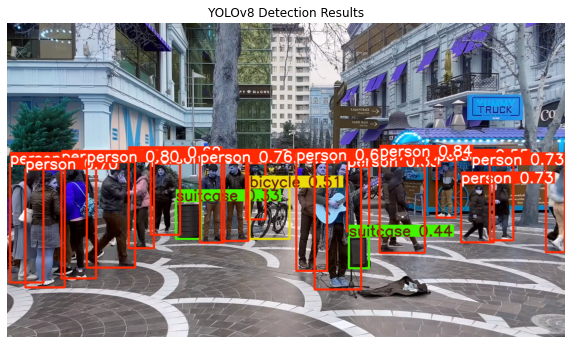

In [44]:
annotated_image = detections.plot()
plt.figure(figsize=(10, 8))
plt.imshow(annotated_image)
plt.axis('off')
plt.title('YOLOv8 Detection Results')
plt.show()

## 6. Detailed Explanation of the Process

1. **Download an Image**: We used the command `wget` to retrieve a public-domain (or openly licensed) image from the internet. You can also use your own images by placing them in the same folder.
2. **Load Model**: We initialized a pre-trained YOLOv8 model (in this case, the "nano" version) by referencing `'yolov8n.pt'`. This model is trained on the [COCO dataset](https://cocodataset.org/) to detect 80 common object classes.
3. **Predict**: We fed our image (`'street_scene.jpg'`) into the model using the `.predict()` method. The model resized the image, applied the neural network forward pass, and performed non-max suppression to remove overlapping boxes.
4. **Results**: The `results[0]` object contains all bounding boxes, class IDs, and confidence scores. YOLOv8 even has a `.names` list to map class IDs to class names (like `person`, `car`, `bicycle`, etc.).
5. **Plot**: We used the built-in `.plot()` function to overlay bounding boxes and labels on the image, making it easy to visualize the output.

### Confidence Threshold
- We set `conf=0.25` in the `.predict()` call, meaning only detections with confidence of 0.25 or higher are shown. You can adjust this up or down to control how strict the detection is.

### Speed & Performance
- On a CPU, detection might be slower (a few seconds) depending on your hardware. On a GPU, YOLOv8 can run in near real-time, especially for smaller models like YOLOv8n or YOLOv8s.

### Common Troubleshooting
- **`pip install` issues**: If your environment doesn't allow direct installation, make sure you have the latest version of `pip`.
- **Image not displaying**: In some terminal-based environments (like a remote server), you won't see the inline plot. You can save the annotated image using `detections.save(save_dir='.')` or similar.


## 7. Extracting Bounding Box Coordinates and Class Labels

If you want to see the raw bounding box data (coordinates, class IDs, confidence scores), you can access the `detections.boxes` property (a *`Boxes`* object). For example:


In [15]:
# Each row in 'boxes' has [x1, y1, x2, y2, confidence, class_id]
print(detections.boxes.xyxy)  # bounding boxes in xyxy format
print(detections.boxes.conf)  # confidence scores
print(detections.boxes.cls)   # class IDs


tensor([[   0.0000,  579.8058,  234.2371, 1078.3430],
        [ 341.0707,  598.4897,  475.0518, 1080.0000],
        [1305.0547,  574.0287, 1407.0811,  962.4803],
        [1739.7437,  675.6058, 1852.3894,  774.8936],
        [1207.0267,  594.0994, 1314.9265,  958.7161],
        [ 150.9038,  681.4214,  218.0701,  949.9731],
        [ 925.1298,  588.5385,  961.5881,  682.0408],
        [1183.7766,  662.0990, 1233.9028,  816.6781],
        [1140.1783,  585.2922, 1177.2792,  668.6116],
        [ 997.8411,  576.8381, 1030.5540,  682.2836],
        [1692.9382,  666.9749, 1852.9658,  772.0330],
        [1051.8933,  579.5993, 1082.2419,  672.9714],
        [1185.5541,  750.7588, 1231.5897,  816.2666],
        [ 152.7487,  796.1995,  219.7397,  948.1009],
        [1030.4456,  577.9373, 1057.4441,  677.3336],
        [1820.2471,  626.3251, 1919.0552,  742.0605],
        [ 181.1949,  691.6924,  891.1928, 1067.1915],
        [ 719.6677,  626.3760,  824.1703,  739.2307],
        [1111.8157,  587.774

You can then map the `class_id` to the human-readable class name by:

```python
class_names = model.names  # e.g. {0: 'person', 1: 'bicycle', ...}
for c in detections.boxes.cls:
    print(class_names[int(c)])
```


## 8. Summary

In this notebook, you learned how to:
1. **Install** the ultralytics YOLO library.
2. **Download** an image from the internet.
3. **Load** a pre-trained YOLOv8 model.
4. **Predict** bounding boxes, class labels, and confidences.
5. **Visualize** the results both automatically (via `.plot()`) and manually (via matplotlib).

This demonstration should help your students understand the end-to-end procedure of object detection using YOLO:
- **Data Input** (images)
- **Model Inference** (neural network forward pass)
- **Results** (bounding boxes, labels, confidence scores)
- **Visualization** (plots and annotated images)

They can experiment with different images, thresholds, or even try YOLOv8s and see how speed and accuracy change.

---
**Happy Teaching!**